In [114]:
import pandas as pd
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [115]:
# file containing indexs of close (< 100km) row indexes from WAMEX from .SHP file containing Nickel Drillhold deposits
# NOTE: rows are repeated!
with open('../eli/wamex_close_coords_to_shp_minedex_terminatedafter12hrs.pickle', 'rb') as file:
    close_coords_indicies = pickle.load(file)

### Subset of Close Coords

In [116]:
# repeats indexes so set to find unique row indexs
close_coords_indicies = list(set(close_coords_indicies))
print(f"\n Sample: {close_coords_indicies[:10]} \n\n Length: {len(close_coords_indicies)}")


 Sample: [131072, 131073, 131084, 131085, 131086, 131087, 131088, 131089, 131090, 131091] 

 Length: 75628


### WAMEX data

 ·      Cobalt associated with nickel (and copper) in so-called orthomagmatic (igneous) mafic to ultramafic volcanic (komatiite)-hosted and intrusion-hosted deposits
 
 
 Cobalt is a chemical element with the symbol Co and atomic number 27. Like nickel, cobalt is found in the Earth's crust only in a chemically combined form, save for small deposits found in alloys of natural meteoric iron. The free element, produced by reductive smelting, is a hard, lustrous, silver-gray metal. Wikipedia
Symbol: Co <br>
Electron configuration: [Ar] 3d74s2 <br>
Atomic number: 27 <br>
Atomic mass: 58.933195 u <br>
Melting point: 1,495 °C <br>
Discovered: 1735 <br>
Discoverer: Georg Brandt <br>

In [117]:
df_wamex_rc = pd.read_csv('../data/wamex/WAMEX_1_Rockchip_Original.csv')
df_wamex_rc.head(2)

C:\Users\elisi\Miniconda3\envs\minerals\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,OBJECTID,DATASET,SAMPLEID,GSWANO,EXTRACT_DA,BATCH_NO,QMAPID,DLAT,DLONG,EASTING,...,W_ppm,WO3_ppm,Y_ppm,Y2O3_ppm,Yb_ppm,Yb2O3_ppm,Zn_ppm,ZnO_ppm,Zr_ppm,ZrO2_ppm
0,1,NaN,229866,NaN,NaN,NaN,NaN,-34.048839,118.176663,NaN,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0
1,2,NaN,229867,NaN,NaN,NaN,NaN,-34.048839,118.176663,NaN,...,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0,-9999.0


In [118]:
df_wamex_rc = df_wamex_rc.iloc[close_coords_indicies,:]
df_wamex_rc.shape

(75628, 143)

### Nickel, Copper and Cobalt Interactions

['Cobalt', 'Magnesium oxide', 'Iron', 'Sulfur', 'Copper', 'Nickel',
        'Iron - ferric oxide', 'Palladium', 'Platinum', 'Gold', 'Silver']

In [119]:
# most common pair in MINEDEX data.
abdundant_minerals = ['Copper', 'Nickel', 'Iron', 'Sulfur', 'Palladium',
                      'Platinum', 'Gold', 'Silver']
critical_mineral = ['Cobalt']

full_to_atomic = {
    "Copper": "Cu",
    "Cobalt": "Co",
    "Nickel": "Ni",
    "Iron": "Fe",
    "Sulfur": "S_pct", # added on
    "Palladium": "Pd_ppb", # added on
    "Platinum": "Pt_ppb", # added on
    "Gold": "Au",
    "Silver": "Ag"
}


In [120]:
new_cols = []
for col in df_wamex_rc.columns: 
    if "ppm" in col:
        new_cols.append(col.split('_')[0])
    else:
        new_cols.append(col)

df_wamex_rc.columns = new_cols

In [121]:
minerals = abdundant_minerals + critical_mineral

minerals_atomic = [full_to_atomic[mineral] for mineral in minerals]
minerals_atomic

['Cu', 'Ni', 'Fe', 'S_pct', 'Pd_ppb', 'Pt_ppb', 'Au', 'Ag', 'Co']

In [122]:
input_cols = ['DLAT', 'DLONG'] + minerals_atomic

In [123]:
df = df_wamex_rc[input_cols]
df.head(5)

,DLAT,DLONG,Cu,Ni,Fe,S_pct,Pd_ppb,Pt_ppb,Au,Ag,Co
131072,-30.704511,121.551388,200.0,1347.0,-9999.0,-9999.0,-9999.0,8.0,0.003,-9999.0,65.0
131073,-30.707096,121.546128,160.0,642.0,-9999.0,-9999.0,-9999.0,-9999.0,0.104,0.2,47.0
131084,-31.768529,119.601723,172.0,19.0,-9999.0,-9999.0,-9999.0,-9999.0,0.460,-9999.0,-9999.0
131085,-31.768086,119.601774,117.0,26.0,-9999.0,-9999.0,-9999.0,-9999.0,0.070,-9999.0,-9999.0
131086,-31.764900,119.600154,52.0,10.0,-9999.0,-9999.0,-9999.0,-9999.0,0.460,-9999.0,-9999.0


In [124]:
def replace_neg9999(val):
    if val == -9999: 
        return 0
    else:
        return val
    
    
def abs_halve_neg_val(val):
#     print(val)
    if val < 0: 
        return abs(val) / 2
    else: 
        return val

df = df.applymap(replace_neg9999)
df = df.applymap(abs_halve_neg_val)

indexs_6666 = df[df.values == -6666].index
df = df.drop(index=indexs_6666)

indexs_0 = df[df.values == 0].index
df = df.drop(index=indexs_0)

In [125]:
df.head(2)

,DLAT,DLONG,Cu,Ni,Fe,S_pct,Pd_ppb,Pt_ppb,Au,Ag,Co
872,15.133076,121.233643,17.0,74.0,2659.9998,0.005,0.5,2.5,0.0005,0.5,12.0
873,15.126450,121.225794,25.0,82.0,3010.0000,0.005,0.5,2.5,0.0005,0.5,12.0


In [135]:
df[minerals_atomic].sum(axis=1).plot

count    1.478000e+03
mean     1.871634e+04
std      5.494106e+04
min      1.585250e+01
25%      1.550031e+03
50%      8.032188e+03
75%      2.881795e+04
max      1.018122e+06
dtype: float64

In [145]:
df[minerals_atomic].sum(axis=1)

872        2766.5053
873        3132.5055
874        3021.5060
875       12671.1210
263388    67624.7800
             ...    
261235     5953.0110
261236     7449.8105
25943      7928.0630
25944      6542.0326
25945      6435.0360
Length: 1478, dtype: float64

In [154]:
# remove really large assay sums, e.g over 10,000 in total
df = df[df[minerals_atomic].sum(axis=1) < 1e4]

<AxesSubplot:ylabel='Frequency'>

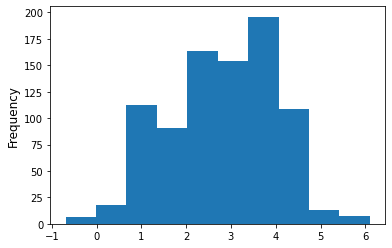

In [156]:
np.log(df['Co']).plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

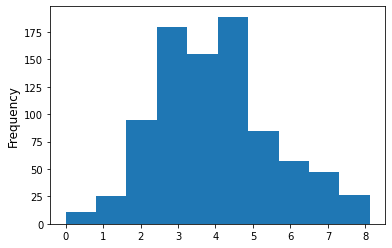

In [157]:
np.log(df['Ni']).plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

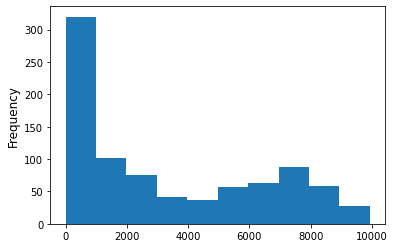

In [160]:
df['Fe'].plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

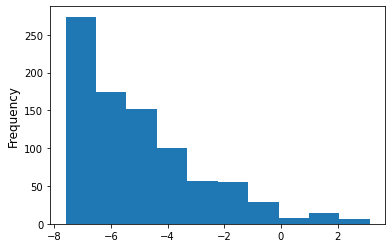

In [161]:
np.log(df['Au']).plot(kind='hist')

### Independent Variables

#### Log transform of Minerals

In [163]:

df[minerals_atomic] = df[minerals_atomic].apply(np.log, axis=1)

C:\Users\elisi\Miniconda3\envs\minerals\lib\site-packages\pandas\core\frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [178]:
# from sklearn.preprocessing import StandardScaler

In [177]:
# df[minerals_atomic][:100].plot()

In [165]:
df = df.reset_index(drop=True)
# df = df.drop(columns=['index'])
df.head()

,DLAT,DLONG,Cu,Ni,Fe,S_pct,Pd_ppb,Pt_ppb,Au,Ag,Co
0,15.133076,121.233643,2.833213,4.304065,7.886081,-5.298317,-0.693147,0.916291,-7.600902,-0.693147,2.484907
1,15.126450,121.225794,3.218876,4.406719,8.009695,-5.298317,-0.693147,0.916291,-7.600902,-0.693147,2.484907
2,15.126005,121.226694,2.890372,4.700480,7.962067,-5.298317,-0.693147,0.916291,-6.907755,-0.693147,2.995732
3,14.224861,120.952254,4.276666,3.091042,7.982758,-3.575551,2.708050,2.995732,-2.263364,-0.693147,1.791759
4,13.805802,120.623672,3.526361,5.036953,8.905173,-3.218876,0.916291,1.609438,-4.828314,-1.386294,2.079442


In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyrolite.plot import pyroplot
from pyrolite.plot.density import density
from pyrolite.comp.codata import close

In [167]:
# df_minerals_log = df[minerals_atomic].apply(lambda x: np.log(x), axis=1)

In [77]:
# fig, ax = plt.subplots(
#     1,
#     3,
#     sharex=True,
#     sharey=True,
#     figsize=(15, 5),
#     subplot_kw=dict(projection="ternary"),
# )
# df_minerals_log.pyroplot.scatter(ax=ax[0], alpha=0.05, c="k")
# for a, mode in zip(ax[1:], ["hist", "density"]):
#     df_minerals_log.pyroplot.density(ax=a, mode=mode)
#     a.set_title("Mode: {}".format(mode), y=1.2)

# plt.tight_layout()
# plt.show()

In [168]:
y = df['Co']
X = df.drop(columns=['Co'])

In [171]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True)

lr = LinearRegression()

lr.fit(X_train, y_train)
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

from sklearn.metrics import mean_squared_error

print(f"Train MSE: {mean_squared_error(train_preds, y_train)}")
print(f"Test MSE: {mean_squared_error(test_preds, y_test)}")

Train MSE: 0.4833450031802475
Test MSE: 0.4267607784886913


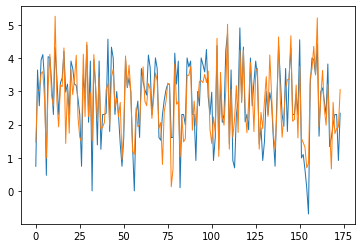

In [172]:
plt.plot(range(0, len(test_preds)), y_test, test_preds)

In [175]:
list(zip(test_preds, y_test))

[(1.4709862973341172, 0.7419373447293773),
 (3.0290903826329085, 3.6428355156125294),
 (3.0389597567062667, 2.5649493574615367),
 (3.532678299465183, 3.9396381724611196),
 (3.5959224079547507, 4.109233174715851),
 (2.7478229971424155, 3.3214324131932926),
 (0.9895444260422428, 0.47000362924573563),
 (3.1159199417972645, 4.041295341132285),
 (4.113575740227546, 4.02535169073515),
 (2.859619013427338, 3.258096538021482),
 (2.5617580751430284, 2.302585092994046),
 (5.2632719538506105, 4.31748811353631),
 (2.6981461964095343, 3.4011973816621555),
 (1.9298931986629966, 2.302585092994046),
 (3.1921517367498593, 3.258096538021482),
 (3.140790835022603, 3.4011973816621555),
 (4.308179651087574, 4.204692619390966),
 (1.4308948363921261, 2.975529566236472),
 (3.1162543651316774, 3.2188758248682006),
 (1.7389111410748894, 2.302585092994046),
 (3.6652304299849883, 3.912023005428146),
 (2.9002636283398537, 3.6888794541139363),
 (3.367764350697288, 3.2188758248682006),
 (4.083616540052393, 3.1780538

#### Random Forrest

In [179]:
rf = RandomForestRegressor(n_estimators=50, min_samples_leaf=5)

rf.fit(X_train, y_train)
train_preds = rf.predict(X_train)
test_preds = rf.predict(X_test)

print(f"Train MSE: {mean_squared_error(train_preds, y_train)}")
print(f"Test MSE: {mean_squared_error(test_preds, y_test)}")

Train MSE: 0.12858268653267507
Test MSE: 0.24000220529250363


In [181]:
pd.DataFrame({"Features": X_train.columns,
              "Importances":rf.feature_importances_}).sort_values(by='Importances', asc)

,Features,Importances
0,DLAT,0.032895
1,DLONG,0.034942
2,Cu,0.026774
3,Ni,0.764679
4,Fe,0.064277
5,S_pct,0.030982
6,Pd_ppb,0.008595
7,Pt_ppb,0.008110
8,Au,0.017701
9,Ag,0.011045
